Pour commencer, nous avons besoin d'une clé API.

Pour obtenir la clé, c'est très simple, il suffit d'aller sur le site de TMDB (The Movie Database), d'enregistrer un nouveau compte et d'utiliser ce nouveau compte pour générer une nouvelle clé API. 
TMDB est une base de données populaire et modifiable par l'utilisateur pour les films et les émissions de télévision.

Une fois la clé obtenue, créez un fichier config.py et mettez-y votre clé avec le code suivant :
tmdb_api_key = "votre clé d'API".

In [1]:
import config # pour cacher les clés de l'API TMDB
import requests # pour effectuer des appels à l'API TMDB
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

import pandas as pd
import matplotlib.pyplot as plt

import itertools
from pandas import json_normalize 
import networkx as nx
import datetime

In [2]:
api_key = config.tmdb_api_key # récupérer la clé API de TMDB à partir du fichier config.py

Dans la suite de notre programme, nous allons nous intéressés au "générique" des films, c'est-à-dire la liste complète des acteurs et de l'équipe. 

Pour obtenir cette information, nous pouvons utiliser une requête comme celle-ci :

In [3]:
query = "https://api.themoviedb.org/3/movie/" + "438631" + "/credits?api_key=" + api_key + "&language=en-US"
response =  requests.get(query)
array = response.json()

Cette application récupère tous les crédits du film "Dune" sur TMDB et les met au format JSON. Le JSON a deux composants : cast et crew. 

Nous pouvons extraire la liste complète des acteurs dans un DataFrame pandas en utilisant le code suivant :

In [4]:
df_cast = json_normalize(array, 'cast')

In [5]:
df_cast.head()

,adult,gender,id,known_for_department,name,original_name,popularity,profile_path,cast_id,character,credit_id,order
0,False,2,1190668,Acting,Timothée Chalamet,Timothée Chalamet,48.498,/cc0kXVI82iosBRA7HoG7lVuUeRh.jpg,13,Paul Atreides,5b4d01bac3a36823d803cd45,0
1,False,1,933238,Acting,Rebecca Ferguson,Rebecca Ferguson,70.778,/6NRlV9oUipeak7r00V6k73Jb7we.jpg,14,Lady Jessica Atreides,5b90742fc3a368222e002f41,1
2,False,2,25072,Acting,Oscar Isaac,Oscar Isaac,47.625,/dW5U5yrIIPmMjRThR9KT2xH6nTz.jpg,53,Duke Leto Atreides,5c50bc070e0a2612cccedcb3,2
3,False,2,16851,Acting,Josh Brolin,Josh Brolin,61.658,/sX2etBbIkxRaCsATyw5ZpOVMPTD.jpg,73,Gurney Halleck,5c64750d9251412fb4feec3e,3
4,False,2,1640,Acting,Stellan Skarsgård,Stellan Skarsgård,24.459,/wCpWjalD8d4MNuAdYupYf3viT1I.jpg,31,Baron Vladimir Harkonnen,5c364b61c3a368273c1c5fee,4


Nous avons maintenant un DataFrame de l'ensemble des acteurs de Dune. Pour visualiser ces données sous forme de réseau, nous devons les transformer. Nous voulons établir une connexion entre chaque personne de la liste des acteurs et chaque autre personne. Le moyen le plus rapide que j'ai trouvé pour le faire est le code suivant :

In [6]:
# Transformons le dataframe en un ensemble de données dyadiques (qui vont de paire) que nous pouvons transformer en un graphe

dyads_cast = pd.DataFrame(list(itertools.combinations(df_cast['name'], 2)))
dyads_cast = dyads_cast.drop_duplicates()
dyads_cast.columns = ['source','target']

Cela crée un DataFrame de "bords" - chaque acteur obtient une connexion avec chaque autre acteur. 

Pour un seul film, ce n'est pas très intéressant. Nous pouvons créer une visualisation simple de ce réseau en transformant le DataFrame en un graphique à l'aide de la bibliotheque NetworkX et en le visualisant avec matplotlib.
NetworkX est une bibliothèque Python pour l'étude des graphes et des réseaux.

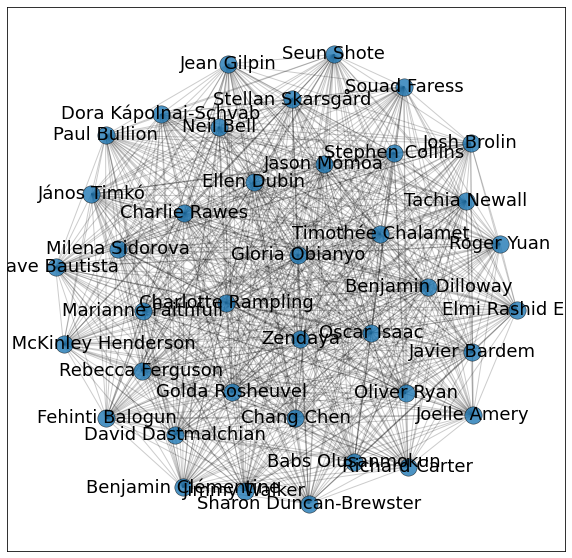

In [7]:
G = nx.from_pandas_edgelist(dyads_cast, 'source', 'target')
pos = nx.spring_layout(G)
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=18)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

Comme je l'ai dit, ce n'est pas intéressant de regarder ce genre de réseau pour un seul film. Nous avons besoin de la liste complète des nominés aux Oscars

In [9]:
movies = pd.read_csv("oscars.csv")

# Il n'y a pas de données pour le film Ascension, donc je l'exclus pour éviter les erreurs plus tard.

movies = movies.loc[movies['original_title'] != "Ascension"]

Nous allons parcourir en boucle la liste des nominés aux Oscars 2022 et obtenir la liste complète des acteurs et de l'équipe de chaque film, puis ajouter chacun d'entre eux à un DataFrame. 

Le code ci-dessous parcourt en boucle la liste de films que nous avons créée, interroge TMDB, extrait un DataFrame pour les acteurs et l'équipe, puis les ajoute à un full_cast_df et un full_crew_df.

In [10]:
# Créons des DataFrames vides pour y ajouter des données.

full_cast_df = pd.DataFrame()
full_crew_df = pd.DataFrame()

for index, row in movies.iterrows():
    movie_id = row['id']
    
    # Recherche des acteurs et de l'équipe d'un film dans TMDB.
    
    query = "https://api.themoviedb.org/3/movie/" + str(movie_id) + "/credits?api_key=" + api_key + "&language=en-US"
    response =  requests.get(query)
    if response.status_code==200: 
        array = response.json()
        title = row['original_title']
        
        # Créons des DataFrames pour la liste des acteurs et de l'équipe de ce film.
        temp_cast = json_normalize(array, 'cast')
        temp_crew = json_normalize(array, 'crew')
        
        # Créons une nouvelle colonne appelée "movie" où vous placerez le titre du film.
        temp_cast = temp_cast.assign(movie=title)
        temp_crew = temp_crew.assign(movie=title)
        
        # Ajoutons la liste des acteurs et de l'équipe de chaque film au cadre de données principal afin d'en avoir 
        # un avec tous les films.
        
        full_cast_df = pd.concat([full_cast_df, temp_cast])
        full_crew_df = pd.concat([full_crew_df, temp_crew])

In [11]:
# On peut explorer les listes des acteurs et de l'équipe séparément, mais je vais simplement les combiner en une seule liste 
# des acteurs et de l'équipe complète.

fullCastAndCrewDF = pd.concat([full_cast_df,full_crew_df])

In [12]:
def getRole(x):
    if pd.isnull(x['character']) == True:
        return(x['movie'] + ": " + x['job'])
    else:
        return(x['movie'] + ": " + "Actor " + x['character'])

In [13]:
fullCastAndCrewDF['role'] = fullCastAndCrewDF.apply(lambda x: getRole(x), axis = 1)

In [14]:
pd.DataFrame(fullCastAndCrewDF.groupby('movie')['name'].count()).sort_values(by='name',ascending=False).head()

,name
movie,
CODA,344
Licorice Pizza,230
tick tick BOOM!,212
Dune,206
Don't Look Up,189


Nous pouvons maintenant répondre à certaines questions en utilisant uniquement ce DF, comme par exemple "quel acteur a joué dans les films les plus nominés aux Oscars en 2022?".

Le code ci-dessous regroupe le DF par nom et par rôle (dans tous les films), puis le trie en fonction des personnes les plus prolifiques (qui produisent beaucoup).

In [15]:
prolifics = fullCastAndCrewDF.groupby(['name']).agg({'movie':lambda x: list(x), 'role':lambda x: list(x)})
prolifics['freq'] = prolifics['movie'].apply(lambda x: len(x))
pd.set_option("display.max_colwidth", -1)
prolifics.sort_values('freq',ascending=False).head(10)

C:\Users\user\AppData\Local\Temp/ipykernel_25764/10657228.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,movie,role,freq
name,,,
Lin-Manuel Miranda,"[tick tick BOOM!, Summer of Soul, tick tick BOOM!, tick tick BOOM!, Encanto, Encanto]","[tick tick BOOM!: Actor Diner Manager (uncredited), Summer of Soul: Actor Self, tick tick BOOM!: Director, tick tick BOOM!: Producer, Encanto: Original Music Composer, Encanto: Songs]",6
Christopher Scarabosio,"[Don't Look Up, Licorice Pizza, Luca, Luca, Luca]","[Don't Look Up: Supervising Sound Editor, Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer, Luca: Supervising Sound Editor, Luca: Sound Re-Recording Mixer]",5
Donald Mowat,"[Dune, Dune, Dune, Dune]","[Dune: Makeup Department Head, Dune: Hair Designer, Dune: Makeup Designer, Dune: Prosthetic Designer]",4
Jonathan Larson,"[tick tick BOOM!, tick tick BOOM!, tick tick BOOM!, tick tick BOOM!]","[tick tick BOOM!: Actor Self (archive footage) (uncredited), tick tick BOOM!: Author, tick tick BOOM!: Music, tick tick BOOM!: Musical]",4
Paul Thomas Anderson,"[Licorice Pizza, Licorice Pizza, Licorice Pizza, Licorice Pizza]","[Licorice Pizza: Screenplay, Licorice Pizza: Director, Licorice Pizza: Director of Photography, Licorice Pizza: Producer]",4
Joel Coen,"[The Tragedy of Macbeth, The Tragedy of Macbeth, The Tragedy of Macbeth, The Tragedy of Macbeth]","[The Tragedy of Macbeth: Screenplay, The Tragedy of Macbeth: Director, The Tragedy of Macbeth: Editor, The Tragedy of Macbeth: Producer]",4
Adam McKay,"[Don't Look Up, Don't Look Up, Don't Look Up, Don't Look Up]","[Don't Look Up: Screenplay, Don't Look Up: Director, Don't Look Up: Producer, Don't Look Up: Story]",4
Destin Daniel Cretton,"[Shang-Chi, Shang-Chi, Shang-Chi]","[Shang-Chi: Screenplay, Shang-Chi: Director, Shang-Chi: Screenstory]",3
Michael Rianda,"[The Mitchells vs the Machines, The Mitchells vs the Machines, The Mitchells vs the Machines]","[The Mitchells vs the Machines: Actor Aaron Mitchell / Furbies / Talking Dog / Wifi Enthusiast (voice), The Mitchells vs the Machines: Director, The Mitchells vs the Machines: Writer]",3


La personne la plus prolifique de notre liste est Lin-Manuel Miranda. Il a produit, réalisé et tenu un petit rôle dans Tick, Tick, BOOM ! tout en écrivant et composant des chansons pour Encanto. Il a également joué un rôle dans le documentaire Summer of Soul, pour un total de 6 crédits dans 2022 nominations aux Oscars.

Plusieurs personnes figurant sur cette liste ont eu plusieurs crédits dans le même film. Paul Thomas Anderson a produit, réalisé, écrit et a été le directeur de la photographie de Licorice Pizza, par exemple. Et si nous excluions les rôles multiples dans le même film ?

In [16]:
fullCastAndCrewDF_noDupes = fullCastAndCrewDF.drop_duplicates(['name','movie'])
prolifics2 = fullCastAndCrewDF_noDupes.groupby(['name']).agg({'movie':lambda x: list(x), 'role':lambda x: list(x)})
prolifics2['freq'] = prolifics2['movie'].apply(lambda x: len(x))
pd.set_option("display.max_colwidth", -1)
prolifics2.sort_values('freq',ascending=False).head(15)

C:\Users\user\AppData\Local\Temp/ipykernel_25764/2349873813.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,movie,role,freq
name,,,
Jonny Greenwood,"[The Power of the Dog, Licorice Pizza, Spencer]","[The Power of the Dog: Original Music Composer, Licorice Pizza: Original Music Composer, Spencer: Original Music Composer]",3
Paul Massey,"[Summer of Soul, House of Gucci, No Time to Die]","[Summer of Soul: Additional Sound Re-Recording Mixer, House of Gucci: Sound Re-Recording Mixer, No Time to Die: Sound Re-Recording Mixer]",3
Francine Maisler,"[Don't Look Up, Dune, Being the Ricardos]","[Don't Look Up: Casting, Dune: Casting, Being the Ricardos: Casting]",3
Lin-Manuel Miranda,"[tick tick BOOM!, Summer of Soul, Encanto]","[tick tick BOOM!: Actor Diner Manager (uncredited), Summer of Soul: Actor Self, Encanto: Original Music Composer]",3
Justin Doyle,"[Don't Look Up, Encanto, Luca]","[Don't Look Up: Sound Effects Editor, Encanto: Sound Effects Editor, Luca: Sound Effects Editor]",3
Jason Cloth,"[Licorice Pizza, Cyrano, House of Gucci]","[Licorice Pizza: Executive Producer, Cyrano: Executive Producer, House of Gucci: Executive Producer]",3
Samson Neslund,"[Licorice Pizza, Encanto, Raya and the Last Dragon]","[Licorice Pizza: Sound Effects Editor, Encanto: Sound Effects Editor, Raya and the Last Dragon: Sound Effects Editor]",3
Maya Rudolph,"[Licorice Pizza, Luca, The Mitchells vs the Machines]","[Licorice Pizza: Actor Gale, Luca: Actor Daniela Paguro (voice), The Mitchells vs the Machines: Actor Linda Mitchell (voice)]",3
Benedict Wong,"[Raya and the Last Dragon, Spiderman: No Way Home, Shang-Chi]","[Raya and the Last Dragon: Actor Tong (voice), Spiderman: No Way Home: Actor Wong, Shang-Chi: Actor Wong]",3


#### Extraction d'un réseau à partir des données.

Maintenant que nous avons un DataFrame avec tout ce que nous voulons, nous pouvons extraire un réseau et effectuer une analyse de réseau sur celui-ci. Il existe deux façons d'extraire ce réseau : nous pouvons considérer les films comme des nœuds et les personnes comme des connexions (ou des bords) entre eux, ou nous pouvons considérer les personnes comme des nœuds et les films comme des bords. 

Tout d'abord, créons un réseau dont les films sont les nœuds.

In [17]:
# Créons une liste de toutes les personnes
fullCastAndCrew = list(fullCastAndCrewDF['name'].drop_duplicates())

# Créons un DataFrame vide pour y ajouter des données.

movie_network = pd.DataFrame()
for x in fullCastAndCrew:
    # Filtrons le DF pour cette personne
    temp = fullCastAndCrewDF.loc[fullCastAndCrewDF['name'] == x]
    
    # Créons un ensemble de données dyadiques pour cette personne entre les films dans lesquels elle se trouve.
    dyads = pd.DataFrame(list(itertools.combinations(temp['movie'], 2)))
    
    # Créons une colonne appelée "name" pour le nom de la personne.
    dyads = dyads.assign(name = x) 
    
    # Concaténons les données de cette personne sur notre DF principal.
    movie_network = pd.concat([movie_network,dyads])
    
# Renommons les colonnes
movie_network.columns = ['name','source','target']

# Débarrassons-nous des références personnelles
movie_network = movie_network[movie_network['source'] != movie_network['target']]

In [18]:
# Exportons en csv pour l'utiliser dans Gephi
movie_network.to_csv("movie_network.csv")

In [19]:
# Créons une liste de tous les films du réseau pour voir si certains ne sont pas du tout connectés.

movie_network_movies = movie_network['source'].tolist() + movie_network['target'].tolist()

In [20]:
# Supprimons les doublons

movie_network_movies = set(movie_network_movies)

In [21]:
# Comparons la liste des films du réseau à la liste originale pour trouver les orphelins.

originalList = movies['original_title'].tolist()
non_connected_movies = list(set(originalList) - set(movie_network_movies))
non_connected_movies

['Drive My Car',
 'Writing with Fire',
 'Lunana: a Yak in the Classroom',
 'Parallel Mothers']

In [22]:
movie_network.loc[(movie_network['target'] == "CODA") & (movie_network['source'] == "tick tick BOOM!")]

,name,source,target
0,Victoria Theodore,tick tick BOOM!,CODA


In [23]:
fullCastAndCrewDF.loc[fullCastAndCrewDF['name'] == "Eskil Vogt"]

,adult,gender,id,known_for_department,name,original_name,popularity,profile_path,cast_id,character,credit_id,order,movie,department,job,role
6,False,2,444892,Writing,Eskil Vogt,Eskil Vogt,2.18,/y5Rg3vdQleveYe7VfyGve4ljDtV.jpg,NaN,NaN,5e15e5055907de0014e53c2d,NaN,The Worst Person in the World,Writing,Writer,The Worst Person in the World: Writer
8,False,2,444892,Writing,Eskil Vogt,Eskil Vogt,2.18,/y5Rg3vdQleveYe7VfyGve4ljDtV.jpg,NaN,NaN,5e618e71459ad6001a53f9c5,NaN,Flee,Writing,Script Consultant,Flee: Script Consultant


In [24]:
# Mettons la description du rôle de la personne dans les deux films dans une nouvelle colonne.

def getDescription(x):
    name = x['name']
    roleInSource = fullCastAndCrewDF.loc[(fullCastAndCrewDF['name'] == name) & (fullCastAndCrewDF['movie'] == x['source'])]['role'].values[0]
    roleInTarget = fullCastAndCrewDF.loc[(fullCastAndCrewDF['name'] == name) & (fullCastAndCrewDF['movie'] == x['target'])]['role'].values[0]
    roles = [roleInSource,roleInTarget]
    return(roles)

movie_network['connection_description'] = movie_network.apply(lambda x: getDescription(x), axis = 1)


Quel est donc le film le plus "connecté" aux autres films nominés aux Oscars ?

Il y a plusieurs façons de répondre à cette question. Tout d'abord, nous pouvons déterminer quels sont les deux films les plus liés.

In [25]:
# Quels sont les films les plus connectés ?

movie_network_freq = movie_network.groupby(["source", "target"]).size().reset_index(name="freq")
movie_network_freq.sort_values('freq',ascending=False).head(10)

,source,target,freq
31,Encanto,Raya and the Last Dragon,10
58,Spiderman: No Way Home,Shang-Chi,8
17,Don't Look Up,Free Guy,7
78,tick tick BOOM!,Encanto,6
75,West Side Story,tick tick BOOM!,6
43,Licorice Pizza,Luca,5
7,CODA,Don't Look Up,5
19,Don't Look Up,Luca,4
12,Cyrano,House of Gucci,4
8,CODA,Free Guy,4


Nous pouvons également calculer le nombre total de "degrés" de chaque nœud, c'est-à-dire le nombre de personnes dans chaque film qui figurent également dans au moins un autre film nommé aux Oscars :

In [26]:
# Transformons le df en graphe avec NetworkX

G = nx.from_pandas_edgelist(movie_network_freq, 'source', 'target', edge_attr='freq')

# Trouvons le degré de chacun dans le réseau

G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['movie','degree']
G_sorted.head()

,movie,degree
0,Licorice Pizza,15
1,Don't Look Up,12
2,No Time to Die,10
3,Spiderman: No Way Home,9
4,tick tick BOOM!,9


Il y a 15 connexions dans la liste des acteurs et de l'équipe de Licorice Pizza qui sont également dans d'autres films de notre liste.

In [27]:
# Affichons tous les liens entre Licorice Pizza et tous les autres films de notre liste
movie_network.loc[(movie_network['source'] == "Licorice Pizza") | (movie_network['target'] == "Licorice Pizza")]

,name,source,target,connection_description
0,Bradley Cooper,Licorice Pizza,Nightmare Alley,"[Licorice Pizza: Actor Jon Peters, Nightmare Alley: Actor Stanton 'Stan' Carlisle]"
1,Bradley Cooper,Licorice Pizza,Nightmare Alley,"[Licorice Pizza: Actor Jon Peters, Nightmare Alley: Actor Stanton 'Stan' Carlisle]"
0,Maya Rudolph,Licorice Pizza,Luca,"[Licorice Pizza: Actor Gale, Luca: Actor Daniela Paguro (voice)]"
1,Maya Rudolph,Licorice Pizza,The Mitchells vs the Machines,"[Licorice Pizza: Actor Gale, The Mitchells vs the Machines: Actor Linda Mitchell (voice)]"
0,Ryan Heffington,Licorice Pizza,tick tick BOOM!,"[Licorice Pizza: Actor Steve, tick tick BOOM!: Choreographer]"
0,Christopher Scarabosio,Don't Look Up,Licorice Pizza,"[Don't Look Up: Supervising Sound Editor, Licorice Pizza: Supervising Sound Editor]"
4,Christopher Scarabosio,Licorice Pizza,Luca,"[Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]"
5,Christopher Scarabosio,Licorice Pizza,Luca,"[Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]"
6,Christopher Scarabosio,Licorice Pizza,Luca,"[Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]"
0,Jonny Greenwood,The Power of the Dog,Licorice Pizza,"[The Power of the Dog: Original Music Composer, Licorice Pizza: Original Music Composer]"


In [28]:
# Nombre de films dans notre réseau
print(str(G.number_of_nodes()) + " films dans le réseau ")

#  Number of connexions in the network
print(str(G.number_of_edges()) + " connexions (personnes) dans le réseau")

33 films dans le réseau 
82 connexions (personnes) dans le réseau


Créons maintenant un réseau où les personnes sont des nœuds et leurs connexions des films.

In [29]:
# Créons un DataFrame vide
people_network = pd.DataFrame()

# Passons en revue les films et créez des dyades entre toutes les personnes dans chaque film.
for x in movies['original_title']:
    
    # Filtrons le df pour "movie"
    temp = fullCastAndCrewDF.loc[fullCastAndCrewDF['movie'] == x]
    
    # Créons des paires de toutes les personnes du film.
    dyads = pd.DataFrame(list(itertools.combinations(temp['name'], 2)))
    
    # Créons une nouvelle colonne appelée "movie".
    dyads = dyads.assign(movie = x)
    
    # Concaténons le réseau au df principale
    people_network = pd.concat([people_network,dyads])

In [30]:
# Renonmons les columes

people_network.columns = ['source','target','movie']

# Débarrassons-nous des références personnelles
people_network = people_network[people_network['source'] != people_network['target']]

In [31]:
# Quelles sont les deux personnes les plus connectées?

people_network = people_network.groupby(["source", "target"]).size().reset_index(name="freq")
people_network.sort_values('freq',ascending=False).head(10)

,source,target,freq
64128,Denis Villeneuve,Donald Mowat,12
77043,Enrico Casarosa,Christopher Scarabosio,9
28353,Bradley James Allan,Destin Daniel Cretton,9
251712,Tormod Ringnes,Kenneth Ladekjær,9
67308,Donald Mowat,Michael Diersing,8
197783,Paul Thomas Anderson,Sera Trimble,8
120038,Joel Coen,Cydney Cornell,8
67323,Donald Mowat,Sam Hudecki,8
128245,Joseph M. Caracciolo Jr.,Donald Mowat,8
67301,Donald Mowat,Mac Ruth,8


Nous pouvons voir que Donald Mowat et Denis Villeneuve ont 12 connexions entre eux. Cela s'explique par le fait que Denis Villeneuve avait trois crédits sur Dune (scénariste, réalisateur et producteur) et que Donald Mowat avait quatre crédits sur Dune (chef du département maquillage, coiffeur, maquilleur et prothésiste). Cela peut être trompeur car ces deux personnes, bien qu'ayant plusieurs rôles, ne sont en réalité que deux personnes. Que se passe-t-il si nous supprimons les rôles en double dans le même film et que nous calculons à nouveau la fréquence des connexions ?

In [32]:
# Supprimer les doublons
people_network_no_dupes = people_network.drop_duplicates()

# Quelles sont les deux personnes les plus connectées ?
people_network_freq = people_network_no_dupes.groupby(["source", "target"]).size().reset_index(name="freq")
people_network_freq.sort_values('freq',ascending=False).head(10)

,source,target,freq
0,Aaron Dessner,Alessandro Bertolazzi,1
176520,Michael Giacchino,Andrew Campbell,1
176490,Michael G. Wilson,Raffaella Cuviello,1
176491,Michael G. Wilson,Reetu Aggarwal,1
176492,Michael G. Wilson,Richard Bain,1
176493,Michael G. Wilson,Rob Shears,1
176494,Michael G. Wilson,Robert Wade,1
176495,Michael G. Wilson,Romolo Pompa,1
176496,Michael G. Wilson,Roxana Alexandru,1
176497,Michael G. Wilson,Rupert Hancock,1


In [33]:
# Transformons le df en graphe avec NetworkX
G = nx.from_pandas_edgelist(people_network_freq, 'source', 'target',edge_attr='freq')

# Trouvons le degré de chacun dans le réseau
G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['movie','degree']
G_sorted.head(20)

,movie,degree
0,Victoria Theodore,526
1,Adam Roffman,500
2,Juliet Loveland,500
3,Sherryn Smith,500
4,Rena Maliszewski,500
5,Lonnie Farmer,500
6,Francine Maisler,489
7,Angela Peri,470
8,Jose Guns Alves,470
9,Lisa Lobel,470


In [34]:
fullCastAndCrewDF.loc[fullCastAndCrewDF['name'] == "Victoria Theodore"]

,adult,gender,id,known_for_department,name,original_name,popularity,profile_path,cast_id,character,credit_id,order,movie,department,job,role
80,False,0,2998800,Acting,Victoria Theodore,Victoria Theodore,0.6,None,212.0,TTB Band Member #2 - Keyboards,6199709035db4500432f8311,81.0,tick tick BOOM!,NaN,NaN,tick tick BOOM!: Actor TTB Band Member #2 - Keyboards
159,False,0,2998800,Acting,Victoria Theodore,Victoria Theodore,0.6,None,NaN,NaN,611eb39b387651005c251759,NaN,CODA,Sound,Musician,CODA: Musician


In [35]:
# Nombre de films dans notre réseau
print(str(G.number_of_nodes()) + " personnes dans le réseau")

# Nombre de connexions dans le réseau
print(str(G.number_of_edges()) + " connexions (films) dans le réseau")

3544 personnes dans le réseau
261375 connexions (films) dans le réseau


Il y a 3 414 personnes dans ce réseau et 245 939 connexions ! C'est l'un des aspects les plus intéressants des réseaux : même si l'ensemble de données initial n'est pas énorme (nous avons commencé avec 37 films), l'analyse de réseau nous permet d'extraire des centaines de milliers de connexions et d'informations qui ne seraient pas disponibles dans une analyse de données standard.

In [36]:
# Calculons la centralité d'interdépendance. Cela peut prendre un certain temps.

print(datetime.datetime.now())

bc = nx.betweenness_centrality(G,k=1000,weight='freq')
print(datetime.datetime.now())

2022-04-19 01:43:58.070759
2022-04-19 01:54:40.073232


Les mesures de centralité sont essentiellement un moyen de mesurer l'importance d'un nœud dans un réseau. Une façon de mesurer l'importance est de compter le nombre de connexions - comme nous l'avons fait ci-dessus avec le nombre de degrés pour chaque nœud. Une autre façon est de trouver la centralité d'interdépendance.

La centralité d'interdépendance est calculée en trouvant le chemin le plus court entre chaque ensemble de deux nœuds. Pour deux nœuds quelconques, il existe un chemin le plus court entre eux. Plus le nombre de chemins les plus courts passant par un nœud est important, plus la centralité d'inter-connectivité est élevée. Les nœuds qui servent de "ponts" ou de "courtiers" entre plusieurs nœuds ou groupes de nœuds ont une "centralité d'inter-connexion" plus élevée.

In [37]:
# Ordonnons les nœuds ayant la plus grande centralité d'interdépendance

bc = pd.DataFrame([bc.keys(), bc.values()]).T
bc.columns= ['names', 'values']  # call them whatever you like
bc = bc.sort_values(by='values', ascending=False)
bc.head(15)

,names,values
940,Jonny Greenwood,0.064492
2323,Andrew Garfield,0.063327
1786,Asiel Hardison,0.060951
1849,Francine Maisler,0.055184
604,Maya Rudolph,0.054819
56,Christopher Scarabosio,0.052365
1356,Ryan Heffington,0.04339
12,Jason Cloth,0.042481
35,Andrew Kalicki,0.0383
1180,Linus Sandgren,0.036723


In [38]:
# liste des nœuds du graphique

G_nodes = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_nodes.columns = ['names','degree']

In [39]:
# Fusionnons les scores d'interdépendance dans une liste de nœuds

people_nodes = pd.merge(G_nodes,bc, how='left', left_on="names",right_on="names")

# Renommer la colonne 'names' -- Gephi est bizarre à ce sujet
people_nodes = people_nodes.rename(columns={'names': 'Id'}) 

In [40]:
# Exportation csv

people_nodes.to_csv("peopleNodes.csv")
people_network_freq.to_csv("peopleEdges.csv")

Tous les films américains de la liste sont connectés, mais certains films internationaux étaient déconnectés. Quatre films, tous internationaux, étaient complètement déconnectés du graphique ("Mères parallèles", "Lunana : un Yak dans la classe", "Conduire ma voiture" et "Écrire avec le feu"). Deux films internationaux nominés ("The Worst Person in the World" et "Flee") sont reliés entre eux, mais aucun autre film. La main de Dieu" est un film italien nominé pour le meilleur film international, mais il est produit par Netflix et partage donc un producteur avec "Don't Look Up" (également un film Netflix) et a le même directeur artistique (Saverio Sammali) que "House of Gucci".